# **Proyecto Final**
## **Equipo 21**

Comenzamos cargando las librerías necesarias:

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import glob
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, MaxPooling2D

Importamos nuestras imágenes que se encuentran en carpeta local descargadas del repositorio de Github con Github Desktop:

In [78]:
#Definimos la ubicación del directorio con nuestras imágenes de entrenamiento
datadir = 'C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/LAPS/'
#Obtenemos los subdirectorios dentro
list_folders = glob.glob(datadir + '*')

#Nombramos las columnas de los archivos .csv
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
#Generamos un dataframe vacio
data = pd.DataFrame()
#Por cada directorio, convertimos su csv en un dataframe temporal y lo unimos al ‘data’
for path in list_folders:
    data_temp = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    data = pd.concat([data,data_temp], ignore_index=True)

#Imprimimos la cantidad de registros y desplegamos los primeros 5
print('Cantidad de registros:',len(data.index))
data.head()

Cantidad de registros: 12864


center  \
0  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
1  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
2  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
3  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   
4  C:\Users\G\Documents\TEC\Maestria\5 abril-juli...   

                                                left  \
0   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
1   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
2   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
3   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   
4   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...   

                                               right  steering  throttle  \
0   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
1   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
2   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
3   C:\Users\G\Documents\TEC\Maestria\5 abril-jul...  0.000000       0.0   
4   C:\Users\G\Documents\TEC\Maestria\5 abril-jul... -0.012859       0.0   

   reverse     speed  
0        0  1.769504  
1        0  1.747100  
2        0  1.724921  
3        0  1.702988  
4        0  1.681361

Separamos los paths de cada imagen (left y right no se incluirán mas delante) para que solo incluyan el subdirectorio, el directorio ‘IMG’, y el nombre de la imagen:

In [79]:
#Función para dividir por ‘\’ y obtenemos las ultimas 3 divisiones:
def path_leaf(path):
    return '/'.join(path.split('\\')[-3:])

#Aplicamos la función a cada columna de los datos con paths de imágenes:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  \
0  EXTRAS/IMG/center_2023_06_18_11_34_10_192.jpg   
1  EXTRAS/IMG/center_2023_06_18_11_34_10_294.jpg   
2  EXTRAS/IMG/center_2023_06_18_11_34_10_396.jpg   
3  EXTRAS/IMG/center_2023_06_18_11_34_10_498.jpg   
4  EXTRAS/IMG/center_2023_06_18_11_34_10_600.jpg   

                                          left  \
0  EXTRAS/IMG/left_2023_06_18_11_34_10_192.jpg   
1  EXTRAS/IMG/left_2023_06_18_11_34_10_294.jpg   
2  EXTRAS/IMG/left_2023_06_18_11_34_10_396.jpg   
3  EXTRAS/IMG/left_2023_06_18_11_34_10_498.jpg   
4  EXTRAS/IMG/left_2023_06_18_11_34_10_600.jpg   

                                          right  steering  throttle  reverse  \
0  EXTRAS/IMG/right_2023_06_18_11_34_10_192.jpg  0.000000       0.0        0   
1  EXTRAS/IMG/right_2023_06_18_11_34_10_294.jpg  0.000000       0.0        0   
2  EXTRAS/IMG/right_2023_06_18_11_34_10_396.jpg  0.000000       0.0        0   
3  EXTRAS/IMG/right_2023_06_18_11_34_10_498.jpg  0.000000       0.0        0   
4  EXTRAS/IMG/right_2023_06_18_11_34_10_600.jpg -0.012859       0.0        0   

      speed  
0  1.769504  
1  1.747100  
2  1.724921  
3  1.702988  
4  1.681361

Es conveniente segmentar los datos para que en su distribución de imágenes, las imágenes con steering de ángulo 0, no sean las mayoritarias. Se decidió dejar el umbral un poco mas alto ya que en pasos adelantes estaremos generando más imágenes para las que tienen en steering ángulos diferentes a 0. 

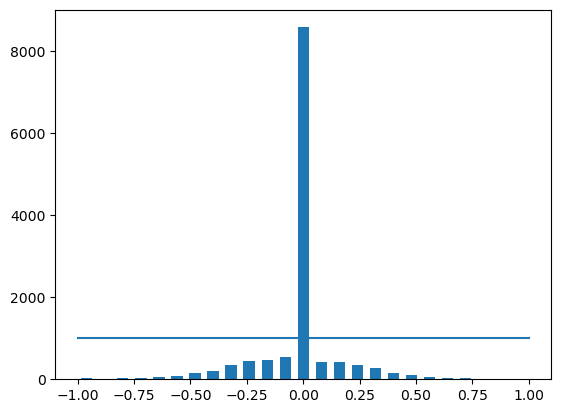

In [80]:
#Separamos los datos por bins
num_bins = 25
#Definimos la cantidad máxima de datos que queremos por bin
samples_per_bin = 1000

#Generamos un histograma para visualizar
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Limitamos cada segmento a 1000 datos:

total data: 12864
removed: 7583
remaining: 5281


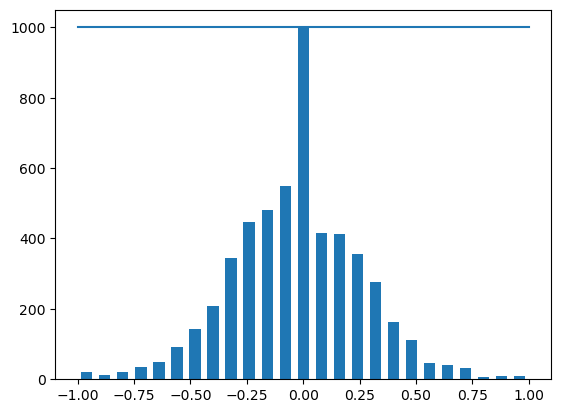

In [81]:
#Imprimimos el total de datos original
print('total data:', len(data))
#Lista para los índices que se eliminaran
remove_list = []
#iteramos por cada bin
for j in range(num_bins):
    #Lista temporal para almacenar los datos a eliminar por bin
    list_ = []
    #Iteramos por todos los datos de steering:
    for i in range(len(data['steering'])):
        #si su valor esta en el bin a trabajar, se agrega a la lista
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    #Aplicamos un shuffle
    list_ = shuffle(list_)
    #Aislamos los datos extras al valor máximo
    list_ = list_[samples_per_bin:]
    #Agregamos a una lista que tendrá los datos a eliminar
    remove_list.extend(list_)

#Imprimimos la cantidad de datos a remover
print('removed:', len(remove_list))
#Los eliminamos del dataframe original
data.drop(data.index[remove_list], inplace=True)
#Imprimimos la cantidad de datos restantes
print('remaining:', len(data))

#Graficamos los bins con los datos restantes
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Ahora generamos una función para extraer del dataframe los paths de las imágenes, así como su valor de steering. Donde únicamente nos quedamos con las imágenes centrales:

In [82]:
#Declaramos la función
def load_img_steering(datadir, df):
    #lista para almacenar los paths
    image_path = []
    #lista para almacenar steering
    steering = []
    #Iteramos por todos los datos
    for i in range(len(data)):
        #Obtenemos la fila de datos
        indexed_data = data.iloc[i]
        #Extraemos la columna correspondiente a la imagen central
        center = indexed_data[0]
        #Agregamos el path de acuerdo al directorio de la imagen
        image_path.append(os.path.join(datadir, center.strip()))
        #agregamos a la lista el valor de steering
        steering.append(float(indexed_data[3]))
    #convertimos listas a numpy arrays
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    #regresamos los arrays
    return image_paths, steerings

#aplicamos la función en los datos
image_paths, steerings = load_img_steering(datadir, data)

Generamos una función para girar 180 grados las imágenes, así como invertir su valor de steering:

In [83]:
def img_flip(image, steering_angle):
    image = cv2.flip(image,1) #cv2 para flip
    steering_angle = -steering_angle #invertimos el ángulo
    return image, steering_angle

Aplicamos la función a todas las imágenes que no tengan un valor de steering 0. Las cuales grabaremos en la carpeta del directorio con un nuevo path que incluya ‘_flipped’ en su nombre. Seguido, guardamos su path y su nuevo valor de steering. Y convertirnos a numpy array para trabajar los datos de las nuevas imágenes. 

In [84]:
#Convertimos a listas 
image_paths_temp = list(image_paths)
steerings_temp = list(steerings)

#Iteramos por todos los paths de las imágenes
for i in len(image_paths):
    #Si el ángulo es diferente a 0…
    if steerings_temp[i] != 0:
        #Obtenemos su path
        img_path = image_paths_temp[i]
        #Leemos la imagen
        img = mpimg.imread(img_path)
        #Aplicamos la función para invertirla
        img, new_steering = img_flip(img,steerings_temp[i])
        #Generamos el nuevo path
        new_path = img_path[:-4]+'_flipped'+img_path[-4:]
        #La guardamos localmente en el nuevo path
        mpimg.imsave(new_path,img)
        #Agregamos a sus listas correspondientes
        image_paths_temp.append(new_path); steerings_temp.append(new_steering)

#Convertimos las listas en numpy arrays
image_paths = np.array(image_paths_temp)
steerings = np.array(steerings_temp)

Ahora segmentamos los datos en entrenamiento y validación. Donde dejaremos para validación un 20% de los datos. 

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, 
                                                      test_size=0.2, random_state=1)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 7684
Valid Samples: 1921


Importante graficar para visualizar la distribución de datos a los segmentos de validación y prueba. Podemos iterar en el la partición aleatoria hasta asegurarnos de tener una distribución de campana aceptable en las dos particiones. 

Text(0.5, 1.0, 'Validation set')

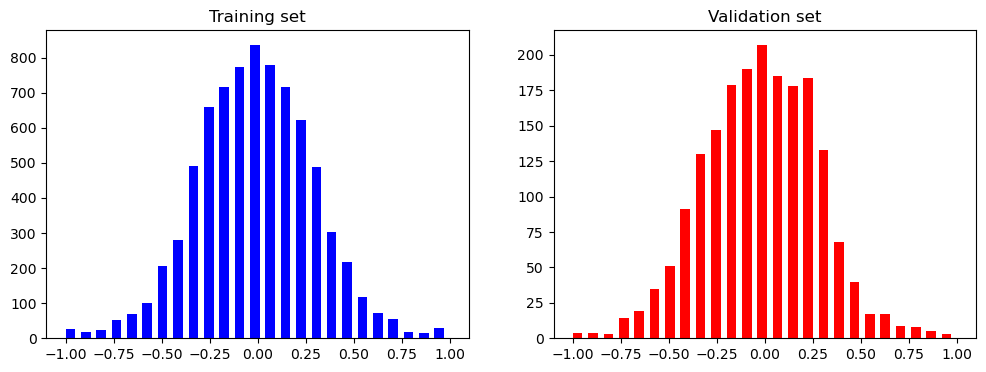

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Parte de la generación del modelo, previo al entrenamiento, es la data augmentation. Generar imágenes con variaciones aleatorias pueden ayudar al modelo a aprender a generalizar mejor. Lo cual terminara preparándolo a comportarse correctamente con datos de entrenada nuevos. 

Comenzamos con la siguiente función de zoom. La cual aplicaremos para variar la escala de las imágenes:

Text(0.5, 1.0, 'Zoomed Image')

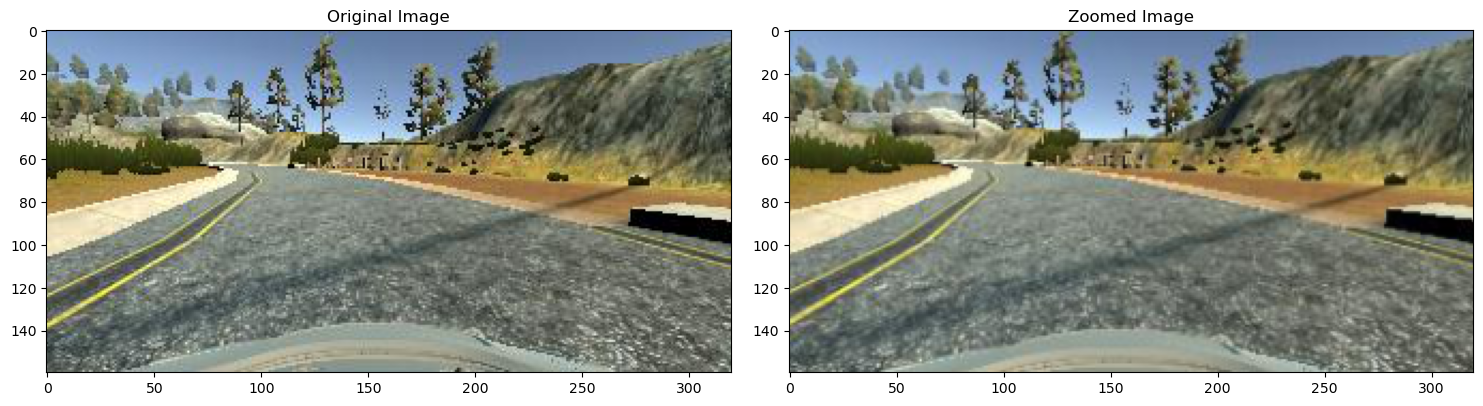

In [58]:
def zoom(image): #declaramos
    #definimos posibles rangos
    zoom = iaa.Affine(scale=(1, 1.15))
    #aplicamos
    image = zoom.augment_image(image)
    return image

#obtenemos una imagen aleatoria para desplegar 
#original vs. modificada con la función
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Generamos la función de pan para trasladar en sus ejes las imágenes y darles enfoque diferente:

Text(0.5, 1.0, 'Panned Image')

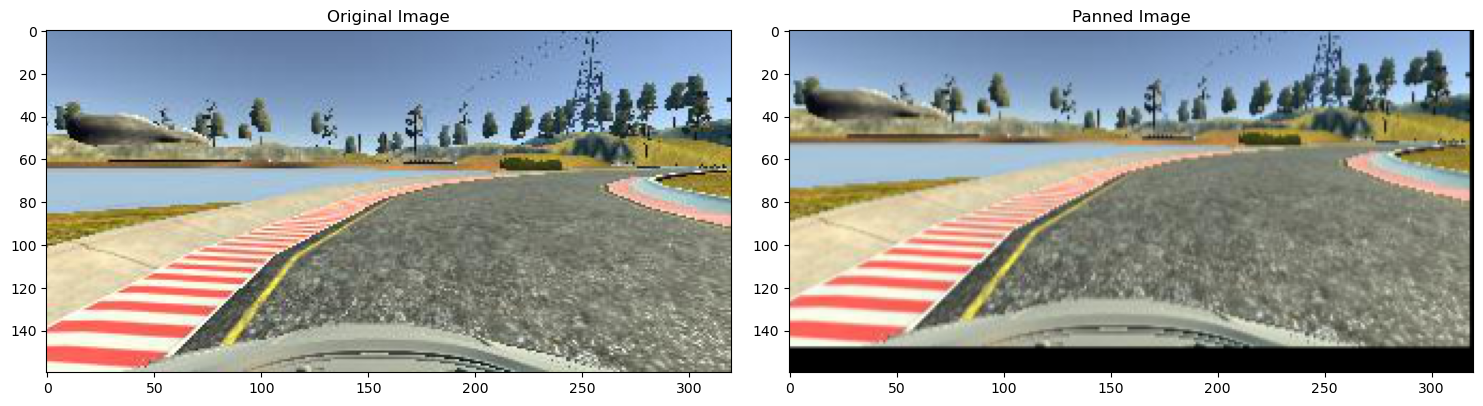

In [61]:
def pan(image): #declaramos
    #Definimos rangos en los dos ejes
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    #Aplicamos 
    image = pan.augment_image(image)
    return image

#obtenemos una imagen aleatoria para desplegar 
#original vs. modificada con la función
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Ahora generamos una función que varie el brillo de las imágenes:

Text(0.5, 1.0, 'Brightness altered image ')

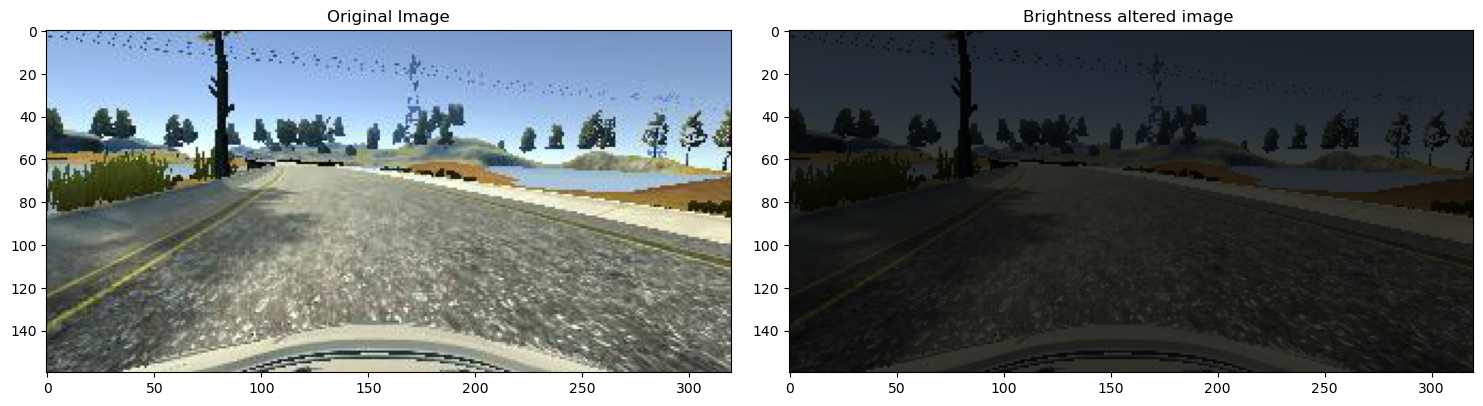

In [62]:
def img_random_brightness(image):#declaramos
    #Definimos rangos 
    brightness = iaa.Multiply((0.2, 1.2))
    #aplicamos
    image = brightness.augment_image(image)
    return image

#obtenemos una imagen aleatoria para desplegar 
#original vs. modificada con la función
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Finalmente, generamos una función que aplique de manera aleatoria las 3 posibles modificaciones que tenemos para nuestras imágenes. Así mismo, mostramos 3 ejemplos de su aplicación:

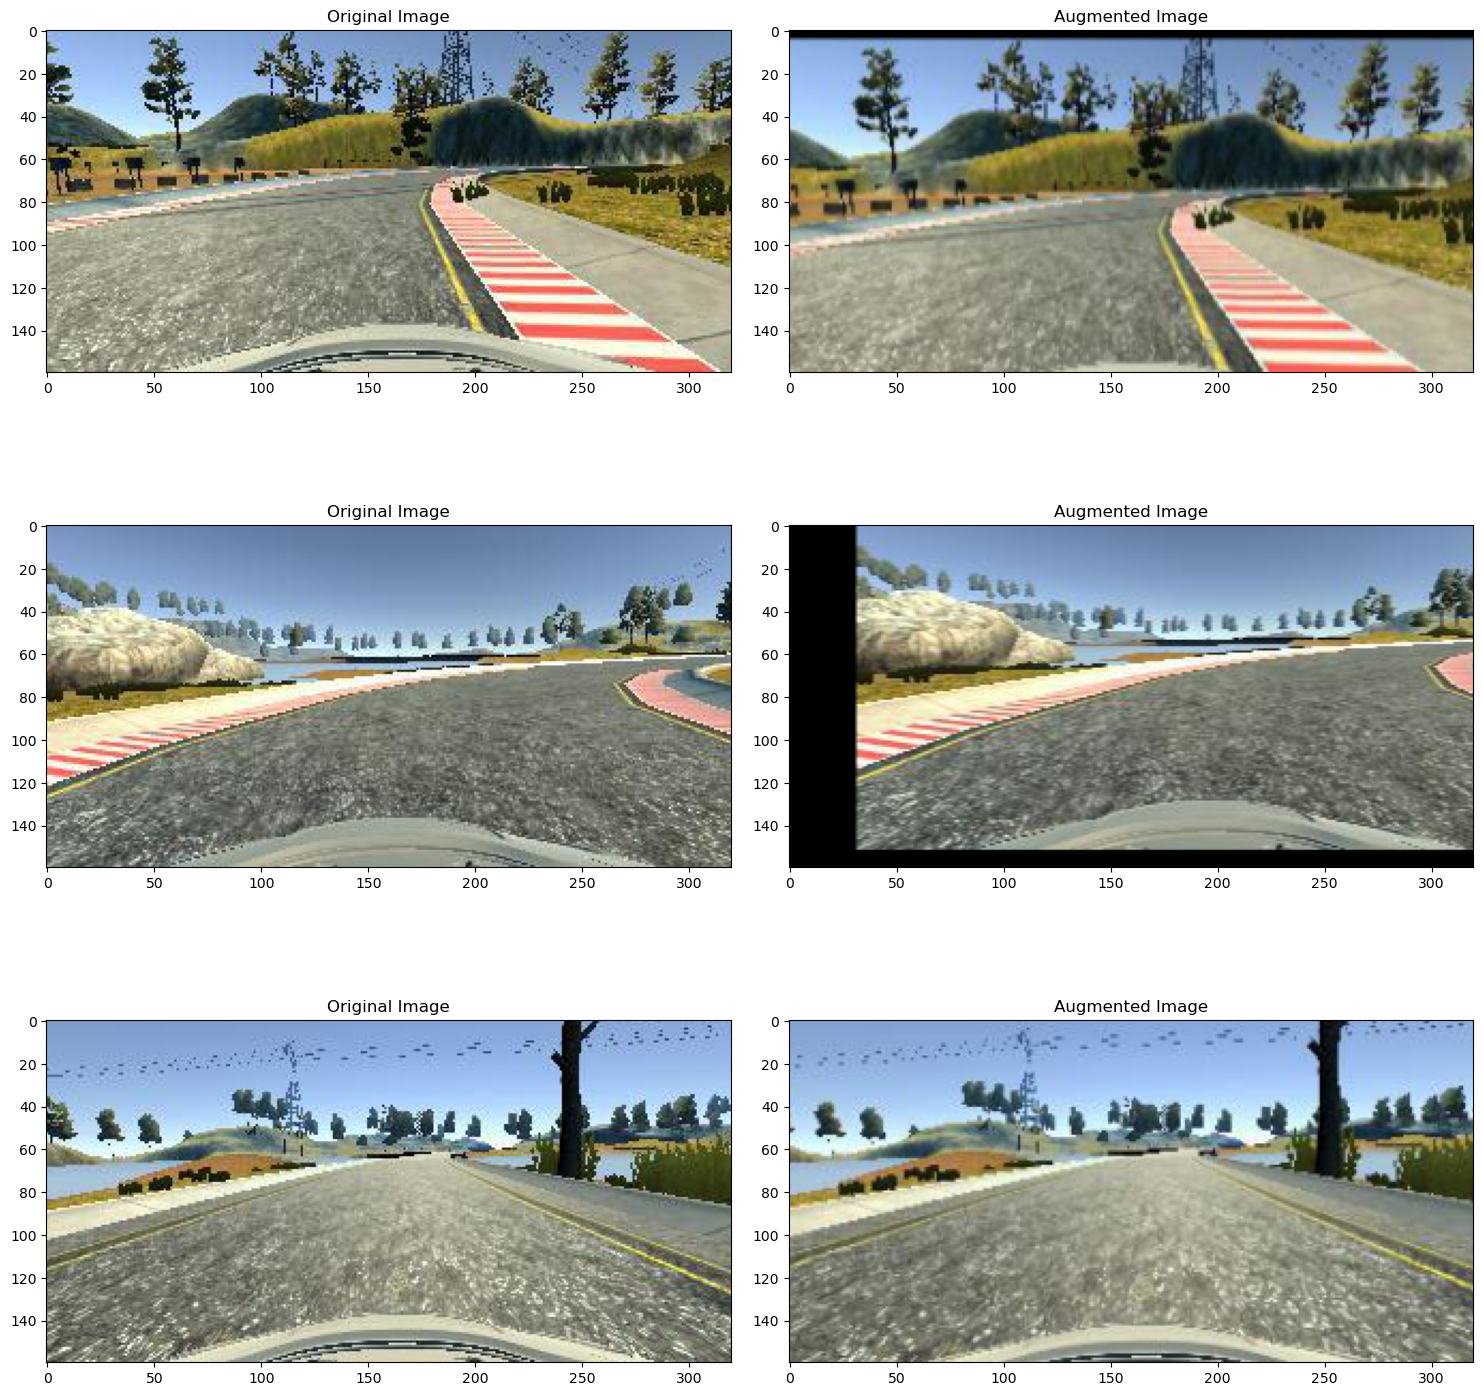

In [66]:
def random_augment(image, steering_angle): #declaramos
    #leemos la imagen
    image = mpimg.imread(image)
    #definimos un numero aleatorio decidir si aplicar cada función
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    return image, steering_angle


#Graficamos las imágenes
ncol = 2
nrow = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

Ocupamos aplicarle procesamiento de imagen a cada imagen para adaptarlas a la entrada de nuestro modelo. Por lo que generamos una función y desplegamos un ejemplo de su aplicación:

Text(0.5, 1.0, 'Preprocessed Image')

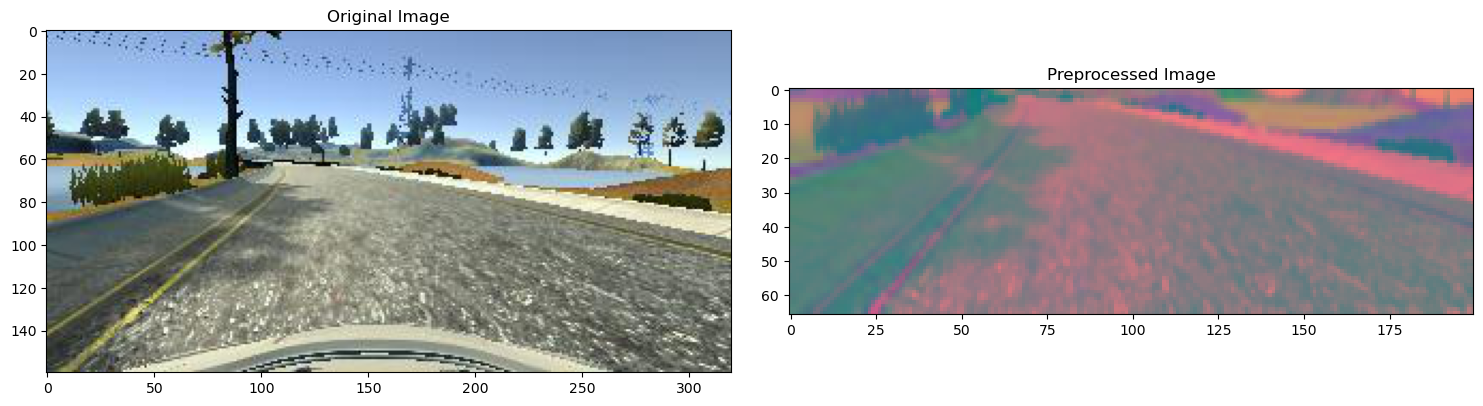

In [67]:
def img_preprocess(img): #declaramos
    img = img[60:135,:,:] #Segmentamos a rango de interés
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) #Convertimos a YUV
    img = cv2.GaussianBlur(img, (3, 3), 0) #Aplicamos Gaussian blur
    img = cv2.resize(img, (200, 66)) #Redimensionamos a 200x66 pixeles
    img = img/255 #Normalizamos
    img = tf.convert_to_tensor(img) #Convertimos a tensor para el modelo
    return img

#Obtenemos imagen original y la procesada
image = image_paths[300]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

#Visualizamos
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Al entrenar nuestro modelo, es necesario usar batches de datos, en este caso de imágenes. Por lo que generamos una función para generar los batches de imágenes con los que se estará entrenando, así como si se les aplicara la función de data augmentation o no:

In [68]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img =[]  #Lista para guardar imágenes
        batch_steering = [] #Lista para valores de steering

        for i in range(batch_size):
            #Índice de la imagen
            random_index = random.randint(0, len(image_paths) - 1)
            #Si es de entrenamiento, pasa por random_augment
            if istraining:
                im, steering = random_augment(image_paths[random_index], 
                                              steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im) #Preprocesamos la imagen
            #Agregamos a listas
            batch_img.append(im)
            batch_steering.append(steering)
            
        #Regresamos las listas como numpy arrays
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Ejemplificamos el uso de nuestro batch_generator con un batch de 1 imagen:

Text(0.5, 1.0, 'Validation Image')

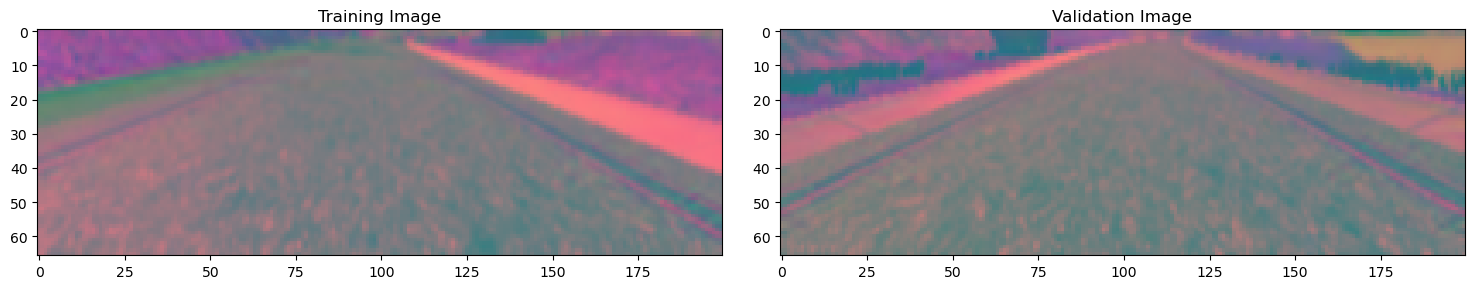

In [69]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Declaramos una función para definir nuestro modelo a utilizar. El cual esta basado en el modelo publicado por nvidia. Con la única diferencia de que se modifico el valor de Dropout a 0.25:

In [70]:
def nvidia_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 24, kernel_size = (5, 5), 
                                     strides=(2, 2), input_shape=(66, 200, 3), 
                                     activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 36, kernel_size = (5, 5), 
                                     strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 48, kernel_size = (5, 5), 
                                     strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), 
                                     activation='elu'))

    model.add(tf.keras.layers.Convolution2D(filters = 64, kernel_size = (3, 3), 
                                            activation='elu'))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(100, activation = 'elu'))

    model.add(tf.keras.layers.Dense(50, activation = 'elu'))

    model.add(tf.keras.layers.Dense(10, activation = 'elu'))

    model.add(tf.keras.layers.Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

Definimos el modelo, y vemos su resumen:

In [71]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

Generamos una función para definir los steps per epoch en el entrenamiento. Donde buscamos que el batch_size multiplicado por los steps_per_epoch sea equivalente a la cantidad de imágenes a trabajar:

In [72]:
def calculate_spe(y):
    return int(math.ceil((1. * y) / batch_size))

Declaramos cuantas imágenes tendrá cada batch. Valor numérico que se encontró a prueba y error; considerando que entre menor suele tender a generalizar mejor. 

In [73]:
batch_size = 32

Entrenamos nuestro modelo, donde para los datos de entrenamiento y validación aplicamos nuestra funcion batch_generator(). Así como la funcion calculate_spe() para los steps_per_epoch. 

In [33]:
history = model.fit(batch_generator(X_train, y_train, batch_size, 1),
                              steps_per_epoch=calculate_spe(len(X_train)),
                              epochs=14,
                              validation_data=batch_generator(X_valid, y_valid, 
                                                              batch_size, 0),
                              validation_steps= calculate_spe(len(X_valid)),
                              verbose=1,
                              shuffle = 1)

Epoch 1/14
241/241 [==============================] - 31s 116ms/step - loss: 0.0976 - val_loss: 0.0605
Epoch 2/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0683 - val_loss: 0.0565
Epoch 3/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0680 - val_loss: 0.0518
Epoch 4/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0586 - val_loss: 0.0447
Epoch 5/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0548 - val_loss: 0.0440
Epoch 6/14
241/241 [==============================] - 30s 123ms/step - loss: 0.0517 - val_loss: 0.0461
Epoch 7/14
241/241 [==============================] - 29s 123ms/step - loss: 0.0498 - val_loss: 0.0437
Epoch 8/14
241/241 [==============================] - 29s 122ms/step - loss: 0.0474 - val_loss: 0.0415
Epoch 9/14
241/241 [==============================] - 27s 111ms/step - loss: 0.0470 - val_loss: 0.0383
Epoch 10/14
241/241 [==============================] - 29s 123ms/step - l

Observamos que nuestra perdida en validación termino siendo 3.55%, lo cual es un valor aceptable. Seguido graficamos su perdida vs. época:

Text(0.5, 0, 'Epoch')

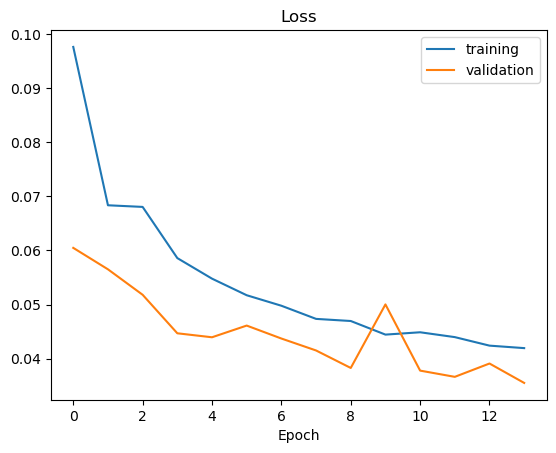

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

Guardamos localmente nuestro modelo:

In [76]:
model.save('C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')

Ahora buscamos utilizarlo en el simular, por lo que comenzamos cargando librerías:

In [1]:
import socketio
import eventlet
import numpy as np
from flask import Flask
import base64
from io import BytesIO
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model

Aplicamos el código ejemplo para la conexión de modelo con simulador:

In [6]:
sio = socketio.Server()

app = Flask(__name__) #'__main__'
speed_limit = 60
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    img = tf.convert_to_tensor(img)
    return img

In [7]:
@sio.on('telemetry')
def telemetry(sid, data):
    #print(np.asarray(Image.open(BytesIO(base64.b64decode(data['image'])))))
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = img_preprocess(image)
    image = np.array([image])
    steering_angle = float(model.predict(image,verbose = 0))
    throttle = 1.0 - speed/speed_limit
    #print('{} {} {}'.format(steering_angle, throttle, speed))
    send_control(steering_angle, throttle)

In [8]:
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit('steer', data = {
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__()
    })

Cargamos el modelo, aplicamos las funciones anteriores, y generamos la conexión:

In [9]:
if __name__ == '__main__':
    model = load_model('C:/Users/G/Documents/GitHub/NA_ProyectoFinal_Equipo_21/model_8.h5')
    app = socketio.Middleware(sio, app)
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

(1896) wsgi starting up on http://0.0.0.0:4567
(1896) accepted ('127.0.0.1', 50334)


Connected


(1896) accepted ('127.0.0.1', 50343)


Connected


127.0.0.1 - - [21/Jun/2023 13:44:04] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 131.570701
wsgi exiting
127.0.0.1 - - [21/Jun/2023 13:45:38] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 152.964342
(1896) wsgi exited, is_accepting=True
